In [1]:
%load_ext autoreload
%autoreload 2

import qubx

%qubxd
import pandas as pd
import numpy as np

from qubx._nb_magic import *
from qubx.data.helpers import loader
from qubx.data.hft import HftDataReader

from qubx.core.metrics import tearsheet
from qubx.backtester.simulator import simulate
from qubx.core.metrics import chart_signals
from qubx.data.readers import AsTrades

from qubx.utils.misc import add_project_to_system_path

add_project_to_system_path("~/devs/Qubx")

from tests.strategies.obi_trader.models.obi_trader import ObiTraderStrategy
from qubx import logger, QubxLogConfig


QubxLogConfig.set_log_level("DEBUG")


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2025, ver. 0.6.1
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


### 1. Check HFT reader separately

In [10]:
reader = HftDataReader()

In [11]:
iterator = reader.read(
    "BINANCE.UM:BTCUSDT",
    start="2025-01-01",
    stop="2025-01-02",
    # start="2025-01-02",
    # stop="2025-01-03",
    data_type="orderbook"
)

In [16]:
reader.close()

In [4]:
list(reader._prefetchers.values())[0].queues["orderbook"].qsize()

0

In [12]:
chunk = next(iterator)

In [13]:
pd.Timestamp(chunk[0][0])

Timestamp('2025-01-01 00:00:01.999000')

In [ ]:
quote_iterator = reader.read("BINANCE.UM:BTCUSDT", start="2025-01-01", stop="2025-01-02", data_type="quote")

In [12]:
quote_chunk = next(quote_iterator)

In [ ]:
quote_chunk[0]

In [14]:
trade_iterator = reader.read(
    "BINANCE.UM:BTCUSDT",
    start="2025-01-01",
    stop="2025-01-02",
    data_type="trade",
    transform=AsTrades(),
)

In [16]:
trade_chunk = next(trade_iterator)

In [18]:
len(trade_chunk)

4882

In [22]:
trade_chunk[:10]

[TradeArray(size=2, volume=0.1, buys=0.1, sells=0.0),
 TradeArray(size=314, volume=20.1, buys=2.1, sells=18.0),
 TradeArray(size=43, volume=1.0, buys=0.3, sells=0.7),
 TradeArray(size=36, volume=1.9, buys=0.1, sells=1.8),
 TradeArray(size=15, volume=1.8, buys=0.0, sells=1.7),
 TradeArray(size=11, volume=0.8, buys=0.1, sells=0.7),
 TradeArray(size=5, volume=0.1, buys=0.0, sells=0.0),
 TradeArray(size=17, volume=0.5, buys=0.1, sells=0.3),
 TradeArray(size=10, volume=0.1, buys=0.0, sells=0.1),
 TradeArray(size=8, volume=0.1, buys=0.0, sells=0.1)]

### 2. Run simulation

Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
Test,29.044,34550.497,0.0,1.415,1.201,12.04,0.0,0.0,1.0,0.0,0.0,2.904,0.0,151.0


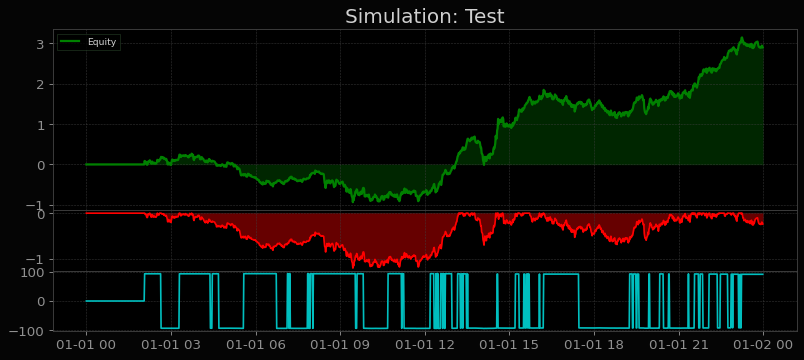

In [21]:
r = simulate(
    strategies={"Test": (stg1 := ObiTraderStrategy(tick_size_pct=0.1, depth=25, threshold=0.5))},
    data=HftDataReader(
        enable_quote=True,
        enable_trade=True,
        enable_orderbook=True,
    ),
    capital=1000,
    instruments=["BINANCE.UM:BTCUSDT"],
    commissions=None,
    start="2025-01-01", stop="2025-01-02",
    portfolio_log_freq="1min",
    debug="WARNING",
)
tearsheet(r, plot_leverage=True)

### 3. Tests

In [19]:
from qubx.core.basics import DataType, MarketEvent, Signal, TriggerEvent
from qubx.core.interfaces import IStrategy, IStrategyContext


class HftTest(IStrategy):
    timeframe: str = "1s"
    tick_size_pct: float = 0.01
    depth: int = 1000
    _n_secs = 0 

    def on_init(self, ctx: IStrategyContext) -> None:
        # ctx.set_base_subscription(DataType.ORDERBOOK[self.tick_size_pct, self.depth])
        ctx.subscribe(DataType.QUOTE)
        ctx.set_event_schedule("1s")
        self._n_secs = 0

    def on_start(self, ctx: IStrategyContext) -> None:
        self._instrument = ctx.instruments[0]

    def on_market_data(self, ctx: IStrategyContext, data: MarketEvent):
        print(ctx.time(), data.type)
        pass

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> list[Signal]:
        signals = []

        # Get current price from orderbook
        q = ctx.quote(self._instrument)
        assert q is not None
        current_price = q.mid_price()

        self._n_secs += 1
        if self._n_secs > 10:
            raise Exception("Stopping")

        return signals

In [20]:
r = simulate(
    # strategies={"Test": (stg1 := ObiTraderStrategy(tick_size_pct=0.1, depth=25, threshold=0.5))},
    strategies={"Test": (stg1 := HftTest(tick_size_pct=0.1, depth=25))},
    data=HftDataReader(
        enable_quote=True,
        enable_trade=True,
        enable_orderbook=True,
        debug=True,
    ),
    capital=1000,
    instruments=["BINANCE.UM:ADAUSDT"],
    commissions=None,
    start="2025-02-18", stop="2025-02-19",
    portfolio_log_freq="1min",
    debug="WARNING",
)
tearsheet(r, plot_leverage=True)

Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2025-02-18T00:00:01.999000000 orderbook
2025-02-18T00:00:02.999000000 orderbook
2025-02-18T00:00:02.999000000 quote
2025-02-18T00:00:03.999000000 orderbook
2025-02-18T00:00:03.999000000 quote
2025-02-18T00:00:04.948880000 trade
2025-02-18T00:00:04.999000000 orderbook
2025-02-18T00:00:04.999000000 quote
2025-02-18T00:00:05.976330000 trade
2025-02-18T00:00:05.999000000 orderbook
2025-02-18T00:00:05.999000000 quote
2025-02-18T00:00:06.475506000 trade
2025-02-18T00:00:06.999000000 orderbook
2025-02-18T00:00:06.999000000 quote
2025-02-18T00:00:07.899261000 trade
2025-02-18T00:00:07.999000000 orderbook
2025-02-18T00:00:07.999000000 quote
2025-02-18T00:00:08.955938000 trade
2025-02-18T00:00:08.999000000 orderbook
2025-02-18T00:00:08.999000000 quote
2025-02-18T00:00:09.918584000 trade
2025-02-18T00:00:09.999000000 orderbook
2025-02-18T00:00:09.999000000 quote
2025-02-18T00:00:10.920719000 trade
2025-02-18T00:00:10.999000000 orderbook
2025-02-18T00:00:10.999000000 quote
2025-02-18T00:00:11.8190

StrategyExceededMaxNumberOfRuntimeFailuresError: 

2025-02-18 00:00:21.000 [❌] STRATEGY FAILED 10 TIMES IN THE ROW - STOPPING ...
